In [14]:
import os, sys
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# To find local version of the library
sys.path.append(ROOT_DIR)
# from humanware.svhn.utils import load_obj

import numpy as np

import torch


from torchvision import transforms
# from torch.utils.data import DataLoader

from utils.dataloader import SVHNDataset
from utils.dataloader import prepare_dataloaders
from utils.transforms import FirstCrop, Rescale, RandomCrop, ToTensor
from utils.utils import load_obj
from utils.visualization import visualize_sample

from train import prepare_dataloaders

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
metadata_dir = ROOT_DIR + '/data/SVHN/'

filename = 'train_metadata'
metadata_train = load_obj(metadata_dir, filename)
metadata_extra = load_obj(metadata_dir, filename)


firstcrop = FirstCrop(0.3)
rescale = Rescale((64, 64))
random_crop = RandomCrop((54, 54))
to_tensor = ToTensor()

transform = transforms.Compose([firstcrop,
                                rescale,
                                random_crop,
                                to_tensor])


## Visualize samples

Image index in dict:  7897


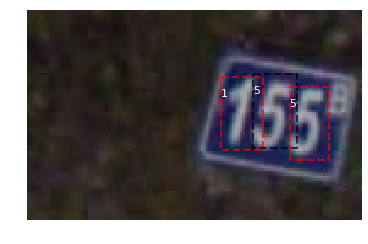

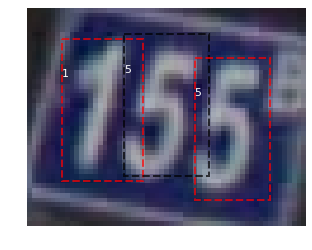

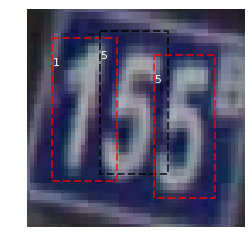

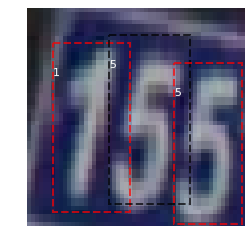

In [9]:
traindata_dir = ROOT_DIR + '/data/SVHN/train/'
extradata_dir = ROOT_DIR + '/data/SVHN/extra/'

firstcrop = FirstCrop(0.3)
rescale = Rescale((64, 64))
random_crop = RandomCrop((54, 54))
to_tensor = ToTensor()


traindata = SVHNDataset(metadata_train, traindata_dir)


transform = transforms.Compose([firstcrop,
                                rescale,
                                random_crop,
                                ])

index = np.random.randint(len(traindata))
print("Image index in dict: ", index)
sample = traindata[index] 
visualize_sample(sample)

for i, tsfrm in enumerate([firstcrop, rescale, random_crop]):
    
    sample = tsfrm(sample)
    visualize_sample(sample)


## Get useful insight into data

In [15]:
n_digits_hist = np.zeros(7)

n_digits_train = 0
n_digits_extra = 0

for ii in metadata_train:
    
    n_digits = int(len(metadata_train[ii]['metadata']['label']))
    n_digits_train += n_digits
    if n_digits < 6:
        n_digits_hist[n_digits] += 1
    else:
        n_digits_hist[6] += 1
        
    
for ii in metadata_extra:
    
    n_digits = int(len(metadata_extra[ii]['metadata']['label']))

    n_digits_extra += n_digits
    
    if n_digits < 6:
        n_digits_hist[n_digits] += 1
    else:
        n_digits_hist[6] += 1



print('total number of digits: ', n_digits_train + n_digits_extra)
print('total number of sequences', sum(n_digits_hist))

total number of digits:  146514
total number of sequences 66804.0


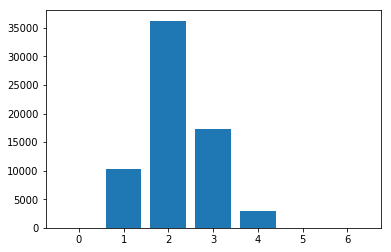

In [17]:
_ = plt.bar(np.arange(len(n_digits_hist)), n_digits_hist)

In [18]:
# Sanity check for total digits

tot = 0
for ii, jj in enumerate(n_digits_hist):
    tot += ii*jj
    
print(tot)

146514.0


In [ ]:
# Get smallest dimensions of images possible
# Slow since you have to load every image into memory

im_width = []
im_height =  []
for jj in range(len(traindata)):
    
    shape = np.asarray(traindata[jj]['image']).shape
    im_height.append(shape[0])
    im_width.append(shape[1])
    
im_width = np.asarray(im_width)
im_height = np.asarray(im_height)

In [ ]:
# Explore dataset for cleaning

# Minimum width and height of images
print("minimum image width", np.min(im_width))
print("minimum image height", np.min(im_height))


#
total = np.sum(np.logical_or(im_height < 28, im_width < 28))

print('total number of image in dataset: ', len(traindata))
print('total number of images that are too small', total)

In [ ]:
## Show sample image that is too small

index = np.argmin(im_height)
visualize_sample(traindata, idx=index)

sample = traindata[index]
print(sample['metadata']['label'])
np.asarray(sample['image']).shape

In [ ]:
# Add example of at least one transform
# use imgaug